In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, classification_report

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
df = pd.read_csv("traffic.csv")
df.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [6]:
df.shape

(48120, 4)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [8]:
df['DateTime'] = pd.to_datetime(df['DateTime'])

In [9]:
df['Hour'] = df['DateTime'].dt.hour
df['Day'] = df['DateTime'].dt.day
df['Month'] = df['DateTime'].dt.month
df['Weekday'] = df['DateTime'].dt.weekday

In [10]:
print("Missing values in each column:\n", df.isnull().sum())

Missing values in each column:
 DateTime    0
Junction    0
Vehicles    0
ID          0
Hour        0
Day         0
Month       0
Weekday     0
dtype: int64


In [11]:
threshold = df['Vehicles'].quantile(0.75)
df['Congestion'] = np.where(df['Vehicles'] > threshold, 1, 0)
print("Congestion threshold (75th percentile):", threshold)
print("Class distribution:\n", df['Congestion'].value_counts())

Congestion threshold (75th percentile): 29.0
Class distribution:
 Congestion
0    36117
1    12003
Name: count, dtype: int64


In [12]:
df_model = df.drop(columns=["ID", "DateTime"])
df_model.head()

,Junction,Vehicles,Hour,Day,Month,Weekday,Congestion
0,1,15,0,1,11,6,0
1,1,13,1,1,11,6,0
2,1,10,2,1,11,6,0
3,1,7,3,1,11,6,0
4,1,9,4,1,11,6,0


**Preprocessing Pipeline**

In [24]:
numeric_features = ['Hour', 'Day', 'Month', 'Weekday']
categorical_features = ['Junction']

In [25]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ])

In [26]:
X = df_model.drop(columns=['Congestion', 'Vehicles'])
y = df_model['Congestion']

In [27]:
X_processed = preprocessor.fit_transform(X)
print("Processed feature shape:", X_processed.shape)

Processed feature shape: (48120, 7)


In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

Model Building, Training and Comparison
We build three models:
1. Logistic Regression

2. Random Forest Classifier

3. XGBoost Classifier

In [29]:
pipe_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

In [30]:
pipe_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

In [31]:
pipe_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

In [32]:
models = {
    "Logistic Regression": pipe_lr,
    "Random Forest": pipe_rf,
    "XGBoost": pipe_xgb
}

In [33]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
roc_auc_scores = {}
for model_name, model_pipeline in models.items():
    scores = cross_val_score(model_pipeline, X_train, y_train, cv=cv, scoring='roc_auc')
    roc_auc_scores[model_name] = np.mean(scores)
    print(f"{model_name}: Mean ROC AUC = {np.mean(scores):.4f}")

Logistic Regression: Mean ROC AUC = 0.9292
Random Forest: Mean ROC AUC = 0.9720
XGBoost: Mean ROC AUC = 0.9809


In [34]:
best_model_name = max(roc_auc_scores, key=roc_auc_scores.get)
print("\nBest model based on cross-validated ROC AUC:", best_model_name)


Best model based on cross-validated ROC AUC: XGBoost


In [35]:
final_pipeline = models[best_model_name]

In [36]:
final_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Hour', 'Day', 'Month',
                                                   'Weekday']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['Junction'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [37]:
y_pred = final_pipeline.predict(X_test)
y_pred_proba = final_pipeline.predict_proba(X_test)[:, 1]

In [38]:
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("Test Accuracy: {:.4f}".format(accuracy))
print("Test ROC AUC: {:.4f}".format(roc_auc))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Test Accuracy: 0.9373
Test ROC AUC: 0.9820

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      7223
           1       0.89      0.86      0.87      2401

    accuracy                           0.94      9624
   macro avg       0.92      0.91      0.92      9624
weighted avg       0.94      0.94      0.94      9624



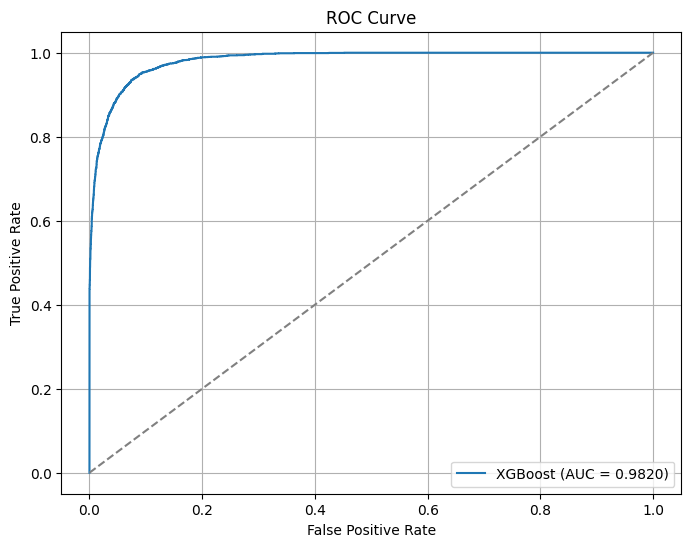

In [39]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'{best_model_name} (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

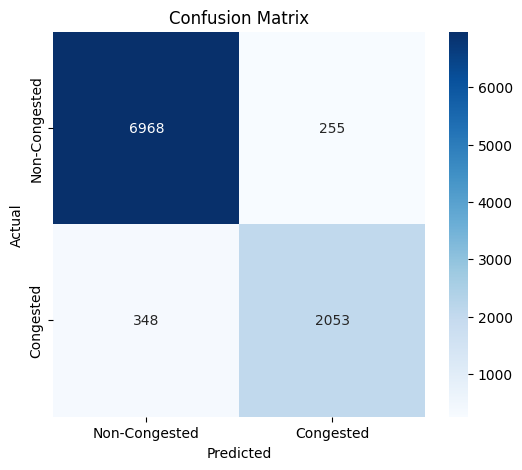

In [40]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Non-Congested", "Congested"],
            yticklabels=["Non-Congested", "Congested"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

**Integrating with GUI**

In [55]:
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output

In [46]:
header = widgets.HTML(
    "<h2 style='color: darkblue; text-align: center;'>Traffic Congestion Prediction Dashboard</h2>"
)
instructions = widgets.HTML(
    "<p style='text-align: center;'>Adjust the input parameters below and click the button to predict the congestion probability.</p>"
)

In [47]:
vehicles_widget = widgets.IntSlider(
    value=50, min=0, max=200, step=1, 
    description='Vehicles:', 
    layout=widgets.Layout(width='300px')
)
hour_widget = widgets.IntSlider(
    value=12, min=0, max=23, 
    description='Hour:', 
    layout=widgets.Layout(width='300px')
)
day_widget = widgets.IntSlider(
    value=15, min=1, max=31, 
    description='Day:', 
    layout=widgets.Layout(width='300px')
)
month_widget = widgets.IntSlider(
    value=6, min=1, max=12, 
    description='Month:', 
    layout=widgets.Layout(width='300px')
)
weekday_widget = widgets.IntSlider(
    value=2, min=0, max=6, 
    description='Weekday:', 
    layout=widgets.Layout(width='300px')
)
# Make sure df is defined; for instance, if you've already loaded your dataset:
junction_widget = widgets.Dropdown(
    options=sorted(df['Junction'].unique()),
    description='Junction:',
    layout=widgets.Layout(width='300px')
)

In [48]:
predict_button = widgets.Button(
    description="Predict Congestion", 
    button_style='success', 
    layout=widgets.Layout(width='200px')
)


In [57]:
output = widgets.Output(layout={'border': '1px solid #ccc', 'padding': '10px', 'width': '500px'})

In [58]:
def on_predict_button_clicked(b):
    with output:
        clear_output()
        # Create a DataFrame from widget values
        input_df = pd.DataFrame({
            'Vehicles': [vehicles_widget.value],
            'Hour': [hour_widget.value],
            'Day': [day_widget.value],
            'Month': [month_widget.value],
            'Weekday': [weekday_widget.value],
            'Junction': [junction_widget.value]
        })
        # Use the final_pipeline to predict; ensure final_pipeline is trained and accessible.
        pred_proba = final_pipeline.predict_proba(input_df)[0,1]
        prediction = "Congested" if pred_proba >= 0.5 else "Non-Congested"
        # Display the result with formatting.
        print(f"Predicted probability of congestion: {pred_proba:.4f}")
        print("Prediction:", prediction)

In [59]:
predict_button.on_click(on_predict_button_clicked)

In [60]:
input_widgets = widgets.VBox(
    [
        vehicles_widget,
        hour_widget,
        day_widget,
        month_widget,
        weekday_widget,
        junction_widget,
        widgets.HBox([predict_button], layout=widgets.Layout(justify_content='center'))
    ],
    layout=widgets.Layout(
        align_items='center', 
        border='2px solid #ccc', 
        padding='10px', 
        width='320px'
    )
)

In [61]:
dashboard = widgets.VBox(
    [header, instructions, input_widgets, output],
    layout=widgets.Layout(align_items='center')
)

In [62]:
display(dashboard)

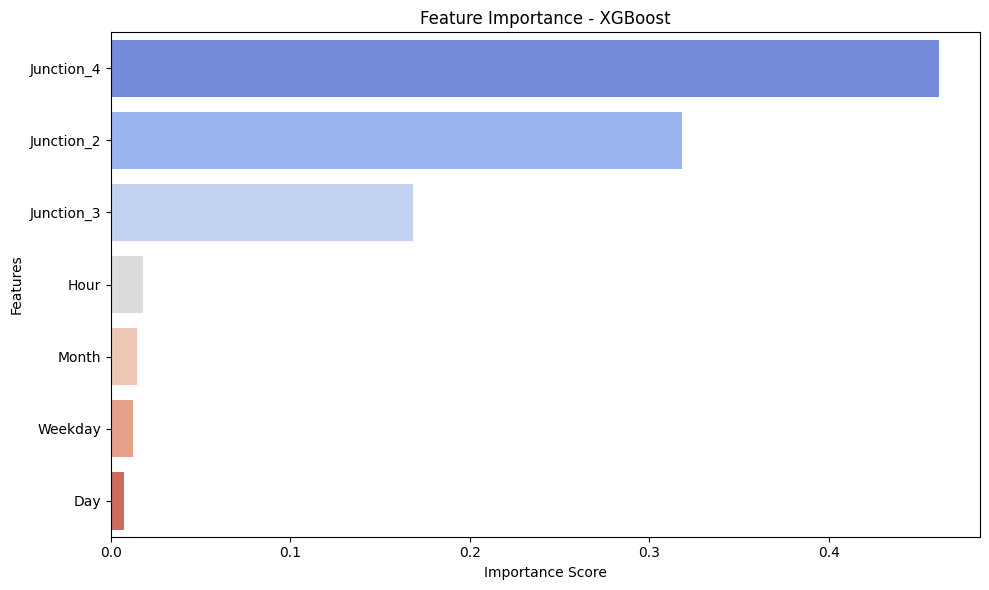

In [63]:
importances = final_pipeline.named_steps['classifier'].feature_importances_
feature_names = final_pipeline.named_steps['preprocessor'].transformers_[0][2] + list(
    final_pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out()
)

feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df, x='Importance', y='Feature', palette='coolwarm')
plt.title(f'Feature Importance - {best_model_name}')
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


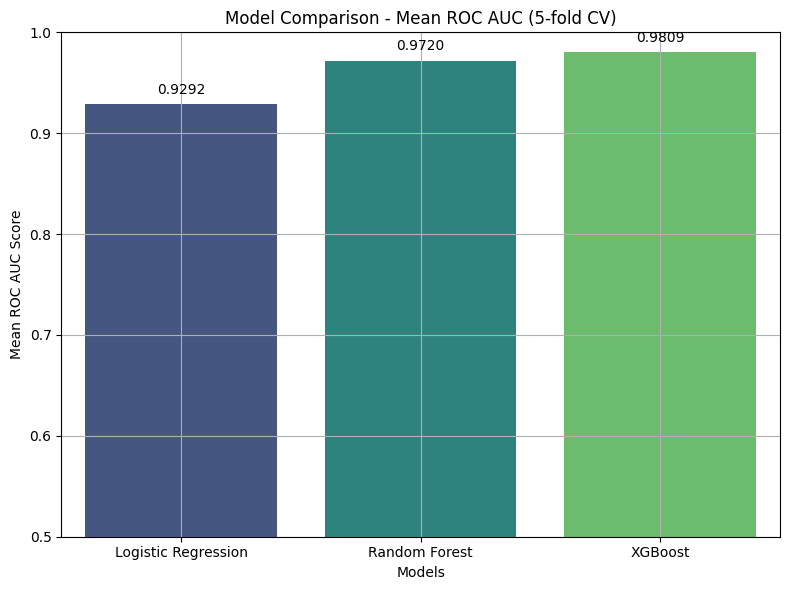

In [64]:
plt.figure(figsize=(8, 6))
sns.barplot(x=list(roc_auc_scores.keys()), y=list(roc_auc_scores.values()), palette='viridis')
plt.title("Model Comparison - Mean ROC AUC (5-fold CV)")
plt.ylabel("Mean ROC AUC Score")
plt.xlabel("Models")
plt.ylim(0.5, 1.0)
for i, score in enumerate(roc_auc_scores.values()):
    plt.text(i, score + 0.01, f"{score:.4f}", ha='center')
plt.grid(True)
plt.tight_layout()
plt.show()


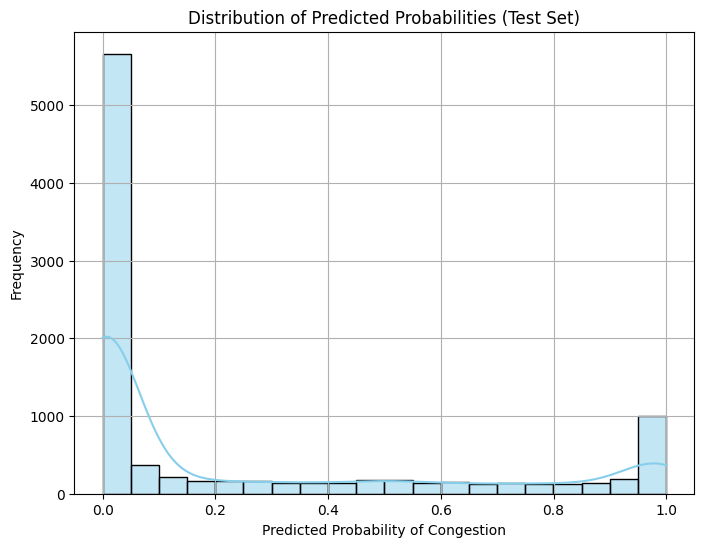

In [65]:
plt.figure(figsize=(8, 6))
sns.histplot(y_pred_proba, bins=20, kde=True, color='skyblue')
plt.title("Distribution of Predicted Probabilities (Test Set)")
plt.xlabel("Predicted Probability of Congestion")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


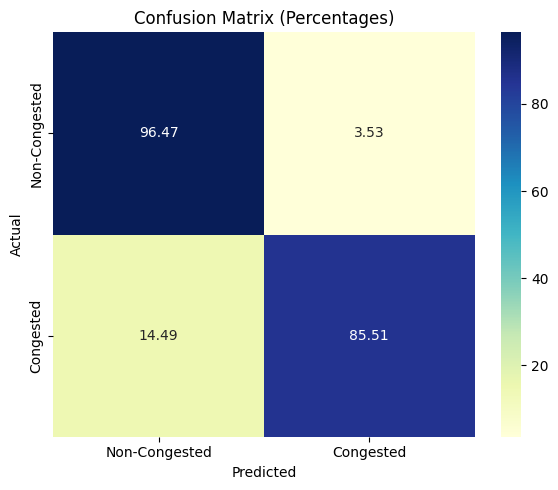

In [66]:
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="YlGnBu",
            xticklabels=["Non-Congested", "Congested"],
            yticklabels=["Non-Congested", "Congested"])
plt.title("Confusion Matrix (Percentages)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [68]:
!pip install shap

  Obtaining dependency information for shap from https://files.pythonhosted.org/packages/1c/d8/83094be435583d2ed8d50fe2280497883b767fe19350bfc0165f4a43a053/shap-0.47.1-cp312-cp312-win_amd64.whl.metadata
  Obtaining dependency information for slicer==0.0.8 from https://files.pythonhosted.org/packages/63/81/9ef641ff4e12cbcca30e54e72fb0951a2ba195d0cda0ba4100e532d929db/slicer-0.0.8-py3-none-any.whl.metadata
  Obtaining dependency information for cloudpickle from https://files.pythonhosted.org/packages/7e/e8/64c37fadfc2816a7701fa8a6ed8d87327c7d54eacfbfb6edab14a2f2be75/cloudpickle-3.1.1-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/490.6 kB ? eta -:--:--
   ---------------------------------------- 0.0/490.6 kB ? eta -:--:--
   ---------------------------------------- 0.0/490.6 kB ? eta -:--:--
   ---------------------------------------- 0.0/490.6 kB ? eta -:--:--
   ---------------------------------------- 0.0/490.6 kB ? eta -:--:--
   ----------------------------

DEPRECATION: Loading egg at c:\program files\python312\lib\site-packages\vboxapi-1.0-py3.12.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..


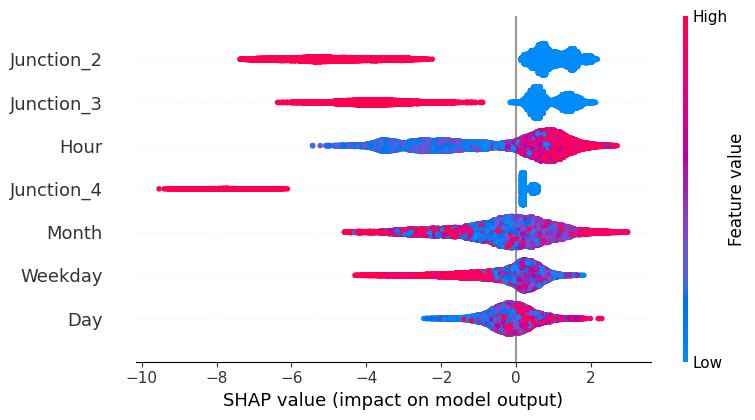

In [69]:
import shap
explainer = shap.Explainer(final_pipeline.named_steps['classifier'])
shap_values = explainer(X_processed)

shap.summary_plot(shap_values, feature_names=feature_names)


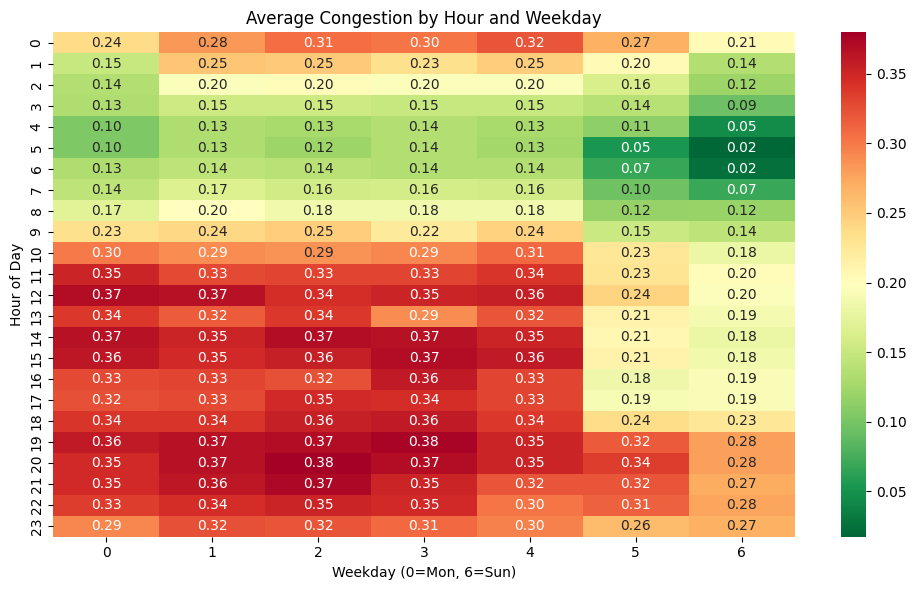

In [70]:
pivot_table = df.pivot_table(index='Hour', columns='Weekday', values='Congestion', aggfunc='mean')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='RdYlGn_r', fmt=".2f")
plt.title("Average Congestion by Hour and Weekday")
plt.xlabel("Weekday (0=Mon, 6=Sun)")
plt.ylabel("Hour of Day")
plt.tight_layout()
plt.show()


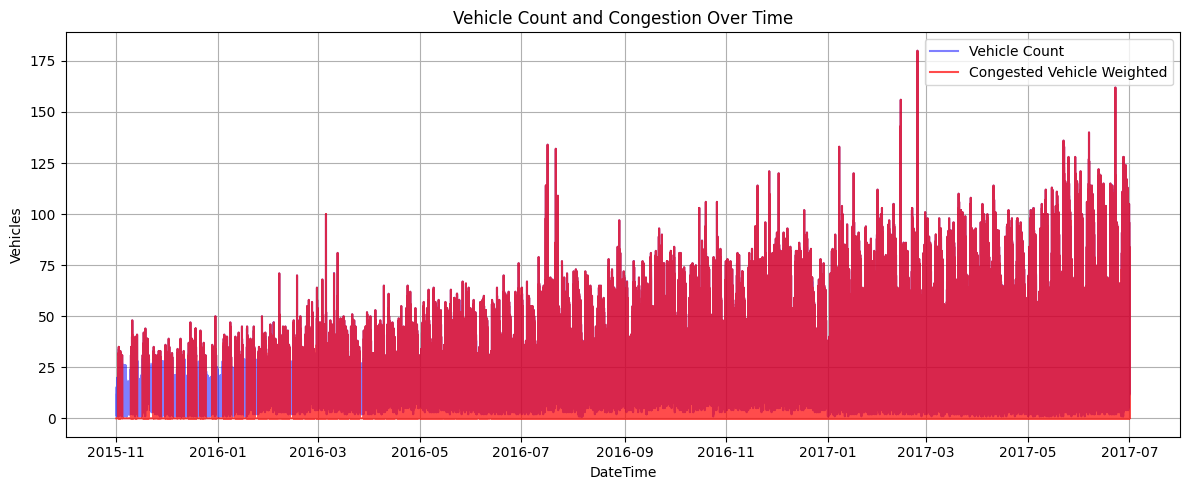

In [71]:
df_sorted = df.sort_values("DateTime")

plt.figure(figsize=(12, 5))
plt.plot(df_sorted['DateTime'], df_sorted['Vehicles'], label='Vehicle Count', color='blue', alpha=0.5)
plt.plot(df_sorted['DateTime'], df_sorted['Congestion'] * df_sorted['Vehicles'], label='Congested Vehicle Weighted', color='red', alpha=0.7)
plt.legend()
plt.xlabel("DateTime")
plt.ylabel("Vehicles")
plt.title("Vehicle Count and Congestion Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()
